# Final Project
## Andrew Messing & Steven Patrick
### Monster Hunter (Kaggle)
#### 5/7/2018

# These are the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import csv
import itertools

%matplotlib inline

# Importing the data

In [2]:
TestPoints = pd.read_csv("test.csv")
TrainPoints = pd.read_csv("train.csv")
TrainPoints.head(2)

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin


# Here is where we normalize the data

In [3]:
colors = ["white", "black", "clear", "blue", "green", "blood"]
for i in range(0,len(TestPoints)):
    c = TestPoints.loc[i,("color")]
    TestPoints.loc[i,("color")] = colors.index(c)


for i in range(0,len(TrainPoints)):
    c = TrainPoints.loc[i,("color")]
    TrainPoints.loc[i,("color")] = colors.index(c)
        
TrainValsLabels = TrainPoints.values[:,1:]
TrainVals = TrainValsLabels[:,:-1]
TrainLabels = TrainValsLabels[:,-1]
TestVals = TestPoints.values[:,1:]
TestIds = TestPoints.values[:,0]

# Here is where we will implement PCA

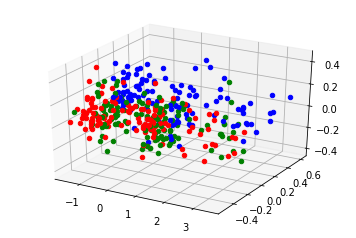

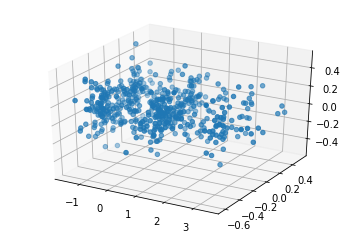

In [4]:
pca = PCA(n_components=3)
pcaTrain = pca.fit_transform(TrainVals)
pcaTest = pca.transform(TestVals)

fig1 = plt.figure()
ax = fig1.add_subplot(111,projection='3d')
for i in range(0,len(TrainPoints)):
    t = TrainPoints.loc[i,'type']
    j = pcaTrain[i]
    if(t == 'Ghoul'):
        ax.scatter(j[0],j[1],j[2],c='r',label = 'Ghoul')
    elif(t == 'Ghost'):
        ax.scatter(j[0],j[1],j[2],c='b',label = 'Ghost')
    else:
        ax.scatter(j[0],j[1],j[2],c='g',label = 'Goblin')
plt.show()

fig2 = plt.figure()
ax = fig2.add_subplot(111,projection='3d')
ax.scatter(pcaTest[:,0],pcaTest[:,1],pcaTest[:,2])
plt.show()

# Here is where we will implement FLD

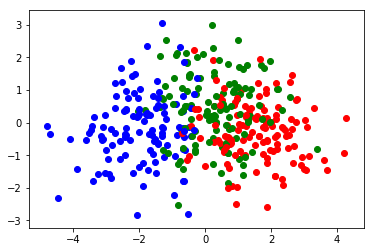

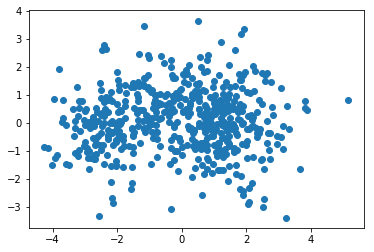

In [5]:
fld = LinearDiscriminantAnalysis(n_components = 7)
fldTrain = fld.fit_transform(TrainVals, TrainLabels)
fldTest = fld.transform(TestVals)
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(0,len(TrainPoints)):
    t = TrainPoints.loc[i,'type']
    j = fldTrain[i]
    if(t == 'Ghoul'):
        ax.scatter(j[0],j[1],c='r',label = 'Ghoul')
    elif(t == 'Ghost'):
        ax.scatter(j[0],j[1],c='b',label = 'Ghost')
    else:
        ax.scatter(j[0],j[1],c='g',label = 'Goblin')
plt.show()

plt.cla()
fig2 = plt.scatter(fldTest[:,0],fldTest[:,1])
plt.show()

# Here is where we will try MPP

# Here is where we will do kNN
k = 3 Accuracy is .66162

In [6]:
k = neighbors.KNeighborsClassifier(3)
k.fit(TrainVals,TrainLabels)
kNNPredictions = {'id': TestIds,'type': k.predict(TestVals)}
dfkNN = pd.DataFrame(data=kNNPredictions)
dfkNN.to_csv('kNN_submission.csv',index=False)

# Here is where we will do BPNN

# Here is where we will do SVM

In [7]:
label_enum = ['Ghost', 'Goblin', 'Ghoul']
TrainLabelEnum = [label_enum.index(i) for i in TrainLabels]

def svm(filename, train, test):
    svm_ = SVC()
    svm_.fit(train, TrainLabelEnum)
    with open(filename, 'w') as csvfile:
        fieldnames = ['id', 'type']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    
        predictions = svm_.predict(test)
        for i in range(len(TestVals)):
            index = TestPoints.loc[i, ('id')]
            enum = predictions[i]
            writer.writerow({'id': index, 'type': label_enum[enum]})

# Attempt with PCA Data (0.71077)
svm('pca_svm.csv', pcaTrain, pcaTest)
        
# Attempt with FLD Data (0.72967)
svm('fld_svm.csv', fldTrain, fldTest)
        
# Attempt with Unreduced Data (0.70888)
svm('ur_svm.csv', TrainVals, TestVals)

# Here is where we will do Decision Tree
Current Accuracy is 0.64083

In [8]:
dt = DecisionTreeClassifier()
dt = dt.fit(TrainVals,TrainLabels)
dtPredictions = {'id': TestIds,'type': dt.predict(TestVals)}
dfdt = pd.DataFrame(data=dtPredictions)
dfdt.to_csv('DecisionTree_submission.csv',index=False)

# Here is where we will do Clustering

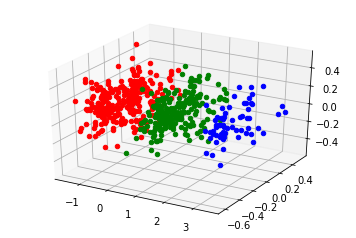

"\n# Mean-Shift\ndef mean_shift(filename, train, test):\n    mean_shift_ = MeanShift()\n    mean_shift_.fit(train)\n    enum_combinations = itertools.combinations(['Ghost', 'Goblin', 'Ghoul'], 3)\n    for index, label_enum in enumerate(enum_combinations):\n        TrainLabelEnum = [label_enum.index(i) for i in TrainLabels]\n        with open('{}_mean_shift_{}.csv'.format(filename, index), 'w') as csvfile:\n            fieldnames = ['id', 'type']\n            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)\n            writer.writeheader()\n    \n            predictions = mean_shift_.predict(test)\n            for i in range(len(TestVals)):\n                index = TestPoints.loc[i, ('id')]\n                enum = predictions[i]\n                print(enum)\n                writer.writerow({'id': index, 'type': label_enum[enum-1]}) \n\n## PCA\nmean_shift('pca', pcaTrain, pcaTest)\n\n## FLD\nmean_shift('fld', fldTrain, fldTest)\n\n        \n## Unreduced\nmean_shift('ur', TrainVal

In [9]:
# KMeans
def kmeans(filename, train, test):
    
    kmeans_ = KMeans(3)
    kmeans_.fit(train)
    enum_combinations = itertools.combinations(['Ghost', 'Goblin', 'Ghoul'], 3)
    for index, label_enum in enumerate(enum_combinations):
        TrainLabelEnum = [label_enum.index(i) for i in TrainLabels]
        with open('{}_kmeans_{}.csv'.format(filename, index), 'w') as csvfile:
            fieldnames = ['id', 'type']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
    
            predictions = kmeans_.predict(test)
            for i in range(len(TestVals)):
                index = TestPoints.loc[i, ('id')]
                enum = predictions[i]
                writer.writerow({'id': index, 'type': label_enum[enum - 1]}) 
    return predictions
    
## PCA
predictions = kmeans('pca', pcaTrain, pcaTest)
fig1 = plt.figure()
ax = fig1.add_subplot(111,projection='3d')
rgb = ['r', 'g', 'b']
for i in range(len(pcaTest)):
    ax.scatter(pcaTest[i][0], pcaTest[i][1], pcaTest[i][2], c=rgb[predictions[i]])
plt.show()

## FLD
kmeans('fld', fldTrain, fldTest)

        
## Unreduced
kmeans('ur', TrainVals, TestVals)

        
# Winner-Takes-All




# Kohonen Maps (SOM)

'''
# Mean-Shift
def mean_shift(filename, train, test):
    mean_shift_ = MeanShift()
    mean_shift_.fit(train)
    enum_combinations = itertools.combinations(['Ghost', 'Goblin', 'Ghoul'], 3)
    for index, label_enum in enumerate(enum_combinations):
        TrainLabelEnum = [label_enum.index(i) for i in TrainLabels]
        with open('{}_mean_shift_{}.csv'.format(filename, index), 'w') as csvfile:
            fieldnames = ['id', 'type']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
    
            predictions = mean_shift_.predict(test)
            for i in range(len(TestVals)):
                index = TestPoints.loc[i, ('id')]
                enum = predictions[i]
                print(enum)
                writer.writerow({'id': index, 'type': label_enum[enum-1]}) 

## PCA
mean_shift('pca', pcaTrain, pcaTest)

## FLD
mean_shift('fld', fldTrain, fldTest)

        
## Unreduced
mean_shift('ur', TrainVals, TestVals)
'''

# Here is where we will do Classifier Fusion

# Additional stuff